In [20]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags_array, csc_array, eye_array
import scipy.sparse.linalg as sla
from pymrm import construct_grad, construct_div, construct_convflux_upwind, interp_cntr_to_stagg_tvd, minmod, newton
from IPython.display import clear_output, display

In [21]:
class ConvectionDiffusionReaction2D:
    def __init__(self):
        self.D_ax = 0.0
        self.v = 1.0
        self.L = 1.0
        self.D_rad = 1e-2
        self.R = 0.1
        self.num_z = 50
        self.num_r = 30
        self.bc_ax = {'a':[self.D_ax,1],'b':[self.v,0], 'd':[self.v,0]}
        self.bc_rad = {'a':[1,0],'b':[0,1], 'd':[0,0]}
        self.k = 0.0
        self.dt = 0.01
        self.z_f = np.linspace(0,self.L,self.num_z+1)
        self.z_c = 0.5*(self.z_f[0:-1]+self.z_f[1:])
        self.r_f = np.linspace(0,self.R,self.num_r+1)
        self.r_c = 0.5*(self.r_f[0:-1]+self.r_f[1:])
        self.init_field()
        self.init_Jac()
        self.freq_out = 10
    
    def init_field(self, c0=0.0):
        self.c = np.full((self.num_z,self.num_r),c0, dtype='float')
    
    def init_Jac(self):
        Jac_accum = (1.0/self.dt)*eye_array(self.num_z*self.num_r,format='csc')
        Jac_react = self.k*eye_array(self.num_z*self.num_r,format='csc')
        Grad, grad_bc = construct_grad(self.c.shape, self.z_f, self.z_c, self.bc_ax, axis=0)
        Conv, conv_bc = construct_convflux_upwind(self.c.shape, self.z_f, self.z_c, self.bc_ax, self.v, axis=0)
        self.Div_ax = construct_div(self.c.shape, self.z_f, nu=0, axis=0)   
        self.Flux_ax = Conv - self.D_ax * Grad
        self.flux_ax_bc = conv_bc - self.D_ax * grad_bc
        self.g_const = self.Div_ax @ self.flux_ax_bc
        self.Jac_const = Jac_accum + self.Div_ax@self.Flux_ax + Jac_react
        Grad, grad_bc = construct_grad(self.c.shape, self.r_f, self.r_c, self.bc_rad, axis=1)
        Div_rad = construct_div(self.c.shape, self.r_f, nu=1, axis=1)   
        self.Flux_rad = - self.D_rad * Grad
        self.flux_rad_bc = - self.D_rad * grad_bc
        self.g_const += Div_rad @ self.flux_rad_bc
        self.Jac_const += Div_rad@self.Flux_rad        
            
    def construct_Jac(self, c, c_old):
        c_f , dc_f= interp_cntr_to_stagg_tvd(self.c, self.z_f, self.z_c, self.bc_ax, self.v, minmod, axis=0)
        dg_conv = self.Div_ax @ (self.v*dc_f).reshape((-1,1))
        g = self.g_const + self.Jac_const @ c.reshape((-1,1)) + dg_conv - c_old.reshape((-1,1))/self.dt
        Jac = self.Jac_const
        return g,Jac
        
    def set_k(self, k):
        self.k = k
        self.init_Jac()
             
    def solve(self, num_timesteps):
        self.plot_pre()          
        Jac = self.Jac_const
        for i in range(num_timesteps):
            c_old = self.c.copy()        
            result = newton(lambda c: self.construct_Jac(c, c_old), c_old, maxfev=1)
            self.c = result.x
            if (i % self.freq_out == 0):
                self.plot()
    
    def plot_pre(self):
        self.fig, self.ax = plt.subplots(figsize=(6, 3))
        self.contour = self.ax.pcolormesh(self.r_f, self.z_f, self.c, shading='flat', cmap='viridis', vmin=0, vmax=1)
        plt.colorbar(self.contour)
        self.ax.set_xlabel('r')
        self.ax.set_ylabel('x')
        
    def plot(self):
        clear_output(wait=True)
        self.contour.set_array(self.c)
        display(self.fig)
        plt.show()

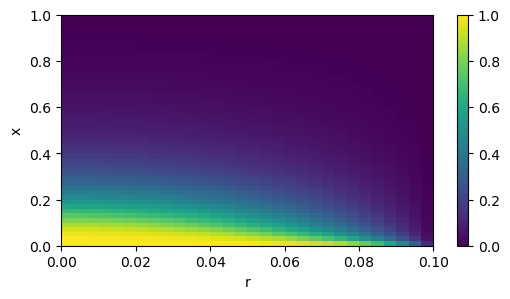

In [22]:
mrm_problem = ConvectionDiffusionReaction2D ()
mrm_problem.solve(100)